In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
from scipy import stats
from adjustText import adjust_text
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [16]:
from scipy import stats

In [34]:
import gseapy as gp #this method requires internet connection

In [2]:
adata = sc.read('annotated.h5ad')

In [3]:
model = scvi.model.SCVI.load('the_model/', adata)

INFO     File the_model/model.pt already downloaded                                                                


In [4]:
# Subset to CMS2 and CMS3 tumor cells only
adata_cms_tumor = adata[
    (adata.obs['condition'] == 'Tumor') & 
    (adata.obs['Cell_Type'].isin(['CMS2', 'CMS3']))
].copy()

# Verify the subset
print(f"Total cells: {adata_cms_tumor.shape[0]}")
print(f"CMS2 cells: {(adata_cms_tumor.obs['Cell_Type'] == 'CMS2').sum()}")
print(f"CMS3 cells: {(adata_cms_tumor.obs['Cell_Type'] == 'CMS3').sum()}")
print(f"Cell types present: {adata_cms_tumor.obs['Cell_Type'].unique()}")
print(f"Conditions present: {adata_cms_tumor.obs['condition'].unique()}")

Total cells: 4659
CMS2 cells: 1761
CMS3 cells: 2898
Cell types present: ['CMS3', 'CMS2']
Categories (2, object): ['CMS2', 'CMS3']
Conditions present: ['Tumor']
Categories (1, object): ['Tumor']


In [6]:
scvi_de = model.differential_expression(
     idx1 = [(adata.obs['Cell_Type'].isin(['CMS2'])) & (adata.obs.condition == 'Tumor')],
     idx2 = [(adata.obs['Cell_Type'].isin(['CMS3'])) & (adata.obs.condition == 'Tumor')],
     mode='change',
    pseudocounts=1e-7,
    test_mode='two'
     )

DE...:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
scvi_de = scvi_de[(scvi_de['is_de_fdr_0.05']) & (abs(scvi_de.lfc_mean) > .5)]
scvi_de = scvi_de.sort_values('lfc_mean')
scvi_de

,proba_de,proba_not_de,bayes_factor,scale1,scale2,pseudocounts,delta,lfc_mean,lfc_median,lfc_std,lfc_min,lfc_max,raw_mean1,raw_mean2,non_zeros_proportion1,non_zeros_proportion2,raw_normalized_mean1,raw_normalized_mean2,is_de_fdr_0.05
AC007952.4,0.9758,0.0242,3.696905,4.958422e-06,0.000279,1.000000e-07,0.25,-6.402499,-6.456627,6.032088,-19.946297,14.383907,0.008489,0.264436,0.019875,0.194962,0.070535,2.939790,True
LINC01285,0.9744,0.0256,3.639229,1.529815e-06,0.000061,1.000000e-07,0.25,-5.164494,-5.098801,4.218278,-18.813622,8.857296,0.004082,0.091376,0.012493,0.075569,0.032602,0.992484,True
HIST2H3D,0.9794,0.0206,3.861649,1.267971e-06,0.000038,1.000000e-07,0.25,-5.048431,-5.188223,4.048493,-18.455311,7.480373,0.002032,0.073676,0.005679,0.068668,0.016306,0.818914,True
NPIPB4,0.9782,0.0218,3.803804,1.166016e-06,0.000039,1.000000e-07,0.25,-4.846774,-4.968182,2.872277,-13.538769,8.157986,0.002000,0.059959,0.010789,0.065562,0.015530,0.620076,True
HDAC11-AS1,0.9556,0.0444,3.069100,2.732539e-07,0.000008,1.000000e-07,0.25,-4.811754,-5.072565,3.591525,-14.009074,8.233421,0.000653,0.016496,0.001136,0.016218,0.004898,0.182052,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EEF1G,0.9412,0.0588,2.773014,5.696159e-05,0.000016,1.000000e-07,0.25,2.533645,2.384098,2.210562,-3.924208,10.049067,0.086568,0.028659,0.208404,0.081090,0.788263,0.267317,True
NDUFC2,0.9546,0.0454,3.045780,1.274835e-04,0.000048,1.000000e-07,0.25,2.589529,2.732924,3.322401,-6.786035,11.563909,0.175409,0.077743,0.224872,0.134231,1.787161,0.652754,True
RBP2,0.9462,0.0538,2.867180,1.101392e-05,0.000002,1.000000e-07,0.25,2.707102,2.453315,2.957045,-5.559719,15.381406,0.016995,0.005193,0.045429,0.009317,0.165932,0.058852,True
C3orf14,0.9566,0.0434,3.092926,9.362790e-06,0.000002,1.000000e-07,0.25,2.874754,2.926603,2.558392,-6.687921,10.379719,0.013365,0.001543,0.046564,0.004141,0.117675,0.013739,True


In [8]:
# Top 20 genes UPREGULATED in CMS3 (most negative lfc_mean = DOWN in CMS2)
top_cms3_genes = scvi_de.head(20).index.tolist()
print("Top 20 UP in CMS3 (DOWN in CMS2):")
print(top_cms3_genes)

# Top 20 genes UPREGULATED in CMS2 (most positive lfc_mean = UP in CMS2)
top_cms2_genes = scvi_de.tail(20).index.tolist()
print("\nTop 20 UP in CMS2 (DOWN in CMS3):")
print(top_cms2_genes)

# Verify the log fold changes for these genes
print("\n=== CMS3-upregulated genes (negative LFC) ===")
print(scvi_de.head(20)[['lfc_mean', 'bayes_factor']])

print("\n=== CMS2-upregulated genes (positive LFC) ===")
print(scvi_de.tail(20)[['lfc_mean', 'bayes_factor']])

Top 20 UP in CMS3 (DOWN in CMS2):
['AC007952.4', 'LINC01285', 'HIST2H3D', 'NPIPB4', 'HDAC11-AS1', 'HIST1H2BB', 'TNFRSF10D', 'PRMT5-AS1', 'MTRNR2L8', 'AL645728.1', 'PATL2', 'NEAT1', 'MALAT1', 'HIST1H4B', 'UVSSA', 'UXT-AS1', 'ANGPTL4', 'SNHG22', 'HIST1H3J', 'ACER2']

Top 20 UP in CMS2 (DOWN in CMS3):
['CDKN3', 'SUMO2', 'FKBP1A', 'KCTD6', 'TDGF1', 'LDHB', 'GCSH', 'GGH', 'TMEM126A', 'PFN2', 'RBP1', 'COPRS', 'TOMM22', 'RAMP2', 'CKMT2', 'EEF1G', 'NDUFC2', 'RBP2', 'C3orf14', 'AP003774.1']

=== CMS3-upregulated genes (negative LFC) ===
            lfc_mean  bayes_factor
AC007952.4 -6.402499      3.696905
LINC01285  -5.164494      3.639229
HIST2H3D   -5.048431      3.861649
NPIPB4     -4.846774      3.803804
HDAC11-AS1 -4.811754      3.069100
HIST1H2BB  -4.754973      3.680101
TNFRSF10D  -4.636607      3.722625
PRMT5-AS1  -4.632751      3.172858
MTRNR2L8   -4.427012      3.365229
AL645728.1 -4.383973      2.813481
PATL2      -4.376794      3.547151
NEAT1      -4.361038      3.496919
MALAT1     

In [10]:
genes_to_show = scvi_de[-20:].index.tolist() + scvi_de[:20].index.tolist()
genes_to_show

['CDKN3',
 'SUMO2',
 'FKBP1A',
 'KCTD6',
 'TDGF1',
 'LDHB',
 'GCSH',
 'GGH',
 'TMEM126A',
 'PFN2',
 'RBP1',
 'COPRS',
 'TOMM22',
 'RAMP2',
 'CKMT2',
 'EEF1G',
 'NDUFC2',
 'RBP2',
 'C3orf14',
 'AP003774.1',
 'AC007952.4',
 'LINC01285',
 'HIST2H3D',
 'NPIPB4',
 'HDAC11-AS1',
 'HIST1H2BB',
 'TNFRSF10D',
 'PRMT5-AS1',
 'MTRNR2L8',
 'AL645728.1',
 'PATL2',
 'NEAT1',
 'MALAT1',
 'HIST1H4B',
 'UVSSA',
 'UXT-AS1',
 'ANGPTL4',
 'SNHG22',
 'HIST1H3J',
 'ACER2']

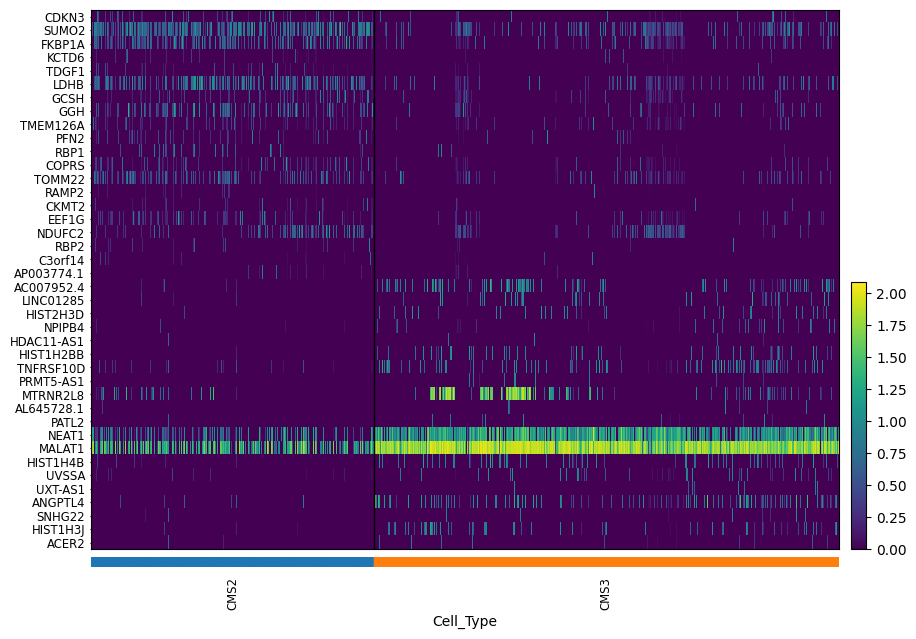

In [11]:
sc.pl.heatmap(adata_cms_tumor, genes_to_show, groupby='Cell_Type', swap_axes=True, 
              log = True)

In [33]:
filename = "DEG_CMS2_vs_CMS3.csv"
scvi_de.to_csv(filename)
print(f"Saved: {filename}")

Saved: DEG_CMS2_vs_CMS3.csv


Looks like you are using a tranform that doesn't support FancyArrowPatch, using ax.annotate instead. The arrows might strike through texts. Increasing shrinkA in arrowprops might help.


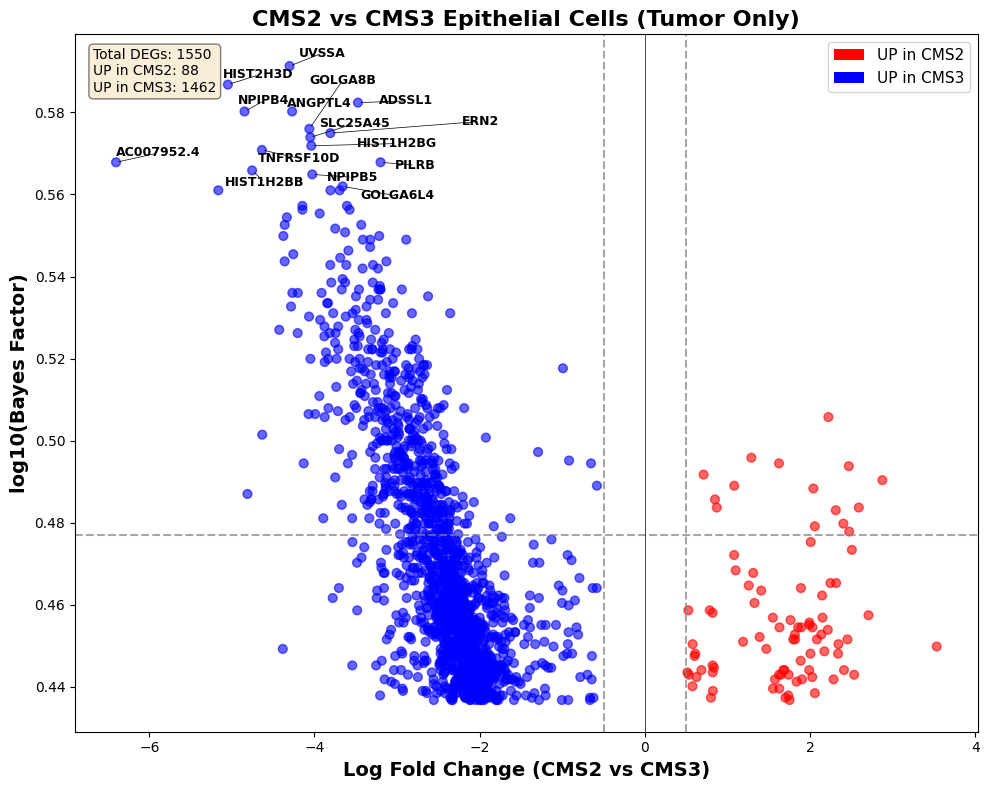

In [12]:
fig, ax = plt.subplots(figsize=(10, 8))
scvi_de['log10_bf'] = np.log10(scvi_de['bayes_factor'] + 1e-10)
colors = ['red' if x > 0 else 'blue' for x in scvi_de['lfc_mean']]

ax.scatter(scvi_de['lfc_mean'], scvi_de['log10_bf'],
           c=colors, alpha=0.6, s=40)

# Label top genes
texts = []
top_genes = scvi_de.nlargest(15, 'log10_bf')  # Top 15 by Bayes factor

for gene_name, gene in top_genes.iterrows():
    texts.append(
        ax.text(
            gene['lfc_mean'],
            gene['log10_bf'],
            gene_name,
            fontsize=9,
            fontweight='bold'
        )
    )

# Adjust text to avoid overlaps
try:
    from adjustText import adjust_text
    adjust_text(
        texts,
        arrowprops=dict(arrowstyle='-', color='black', lw=0.5),
        expand_points=(1.5, 1.5),
        force_points=(0.5, 0.5)
    )
except ImportError:
    print("Install adjustText: pip install adjustText")

ax.axhline(y=np.log10(3), color='gray', linestyle='--', alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.7)
ax.axvline(x=-0.5, color='gray', linestyle='--', alpha=0.7)

ax.set_xlabel('Log Fold Change (CMS2 vs CMS3)', fontsize=14, fontweight='bold')
ax.set_ylabel('log10(Bayes Factor)', fontsize=14, fontweight='bold')
ax.set_title('CMS2 vs CMS3 Epithelial Cells (Tumor Only)', fontsize=16, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='UP in CMS2'),
    Patch(facecolor='blue', label='UP in CMS3'),
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=11, frameon=True)

# Add summary stats box
n_up_cms2 = (scvi_de['lfc_mean'] > 0).sum()
n_up_cms3 = (scvi_de['lfc_mean'] < 0).sum()
n_total = len(scvi_de)

textstr = f'Total DEGs: {n_total}\nUP in CMS2: {n_up_cms2}\nUP in CMS3: {n_up_cms3}'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.savefig('volcano_CMS2_vs_CMS3_tumor1.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:
# List of key genes to check
key_genes = ['MALAT1']

# Check if genes are in your dataset
available_genes = [g for g in key_genes if g in adata.var_names]
print(f"Available genes: {available_genes}")

Available genes: ['MALAT1']


In [19]:
sc.tl.score_genes(adata_cms_tumor,key_genes,score_name='exp')

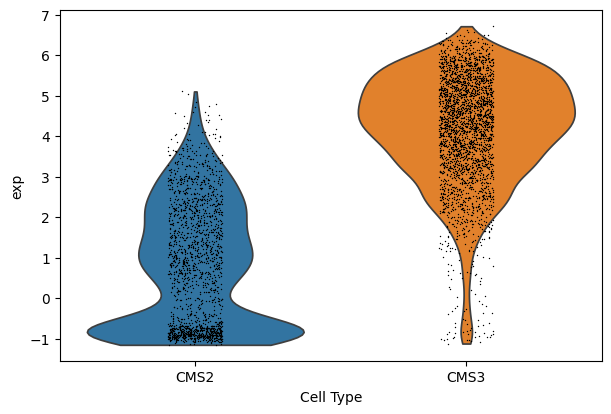

In [20]:
sc.pl.violin(adata_cms_tumor,'exp',groupby='Cell_Type')

In [21]:
a = adata_cms_tumor[adata_cms_tumor.obs.Cell_Type == 'CMS2'].obs.exp.values
b = adata_cms_tumor[adata_cms_tumor.obs.Cell_Type == 'CMS3'].obs.exp.values
stats.mannwhitneyu(a, b)

MannwhitneyuResult(statistic=310913.0, pvalue=0.0)

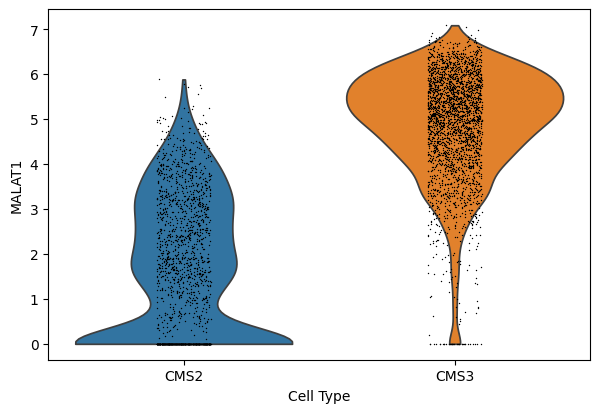

In [22]:
sc.pl.violin(adata_cms_tumor,'MALAT1',groupby='Cell_Type')

### go

In [36]:
subset= adata_cms_tumor.copy()

In [37]:
enr_down = gp.enrichr(gene_list= scvi_de[scvi_de['lfc_mean'] < 0].index.tolist(),
                 gene_sets=['KEGG_2021_Human','GO_Biological_Process_2023'],
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = subset.var_names.tolist()
                )


In [38]:
enr_down.results

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Salivary secretion,0.000055,0.015717,0,0,3.776370,3.701589e+01,PRKCG;CHRM3;ADCY4;ITPR1;ITPR2;PRKCA;ADRB1;ATP1...
1,KEGG_2021_Human,ECM-receptor interaction,0.000401,0.056917,0,0,3.051117,2.386580e+01,LAMA2;LAMB2;LAMA3;FN1;LAMC2;HSPG2;THBS1;THBS3;...
2,KEGG_2021_Human,Calcium signaling pathway,0.000896,0.066038,0,0,2.079417,1.459165e+01,CHRM3;CHRNA7;ADCY4;ITPR1;ATP2A3;ITPR2;ADRB1;CA...
3,KEGG_2021_Human,Nicotine addiction,0.000930,0.066038,0,0,11.155628,7.786853e+01,GABRB3;CHRNA7;GABRE;GRIN2B;GRIN2D
4,KEGG_2021_Human,Aldosterone synthesis and secretion,0.001378,0.078290,0,0,2.654167,1.748266e+01,PRKCG;ITPR1;ADCY4;ITPR2;PRKCA;CACNA1D;ATP1B2;C...
...,...,...,...,...,...,...,...,...,...
3932,GO_Biological_Process_2023,Mitochondrial Gene Expression (GO:0140053),0.999974,0.999996,0,0,0.089243,2.320072e-06,MTG1
3933,GO_Biological_Process_2023,Ubiquitin-Dependent Protein Catabolic Process ...,0.999985,0.999996,0,0,0.374913,5.721742e-06,KLHL15;KIF14;OTUD7A;RC3H1;AMBRA1;FBXL22;UBXN11...
3934,GO_Biological_Process_2023,Ribonucleoprotein Complex Biogenesis (GO:0022613),0.999992,0.999996,0,0,0.077410,6.162626e-07,SPPL2B
3935,GO_Biological_Process_2023,Translation (GO:0006412),0.999995,0.999996,0,0,0.168817,7.695220e-07,EEF2K;MTG1;RRBP1;GTPBP2


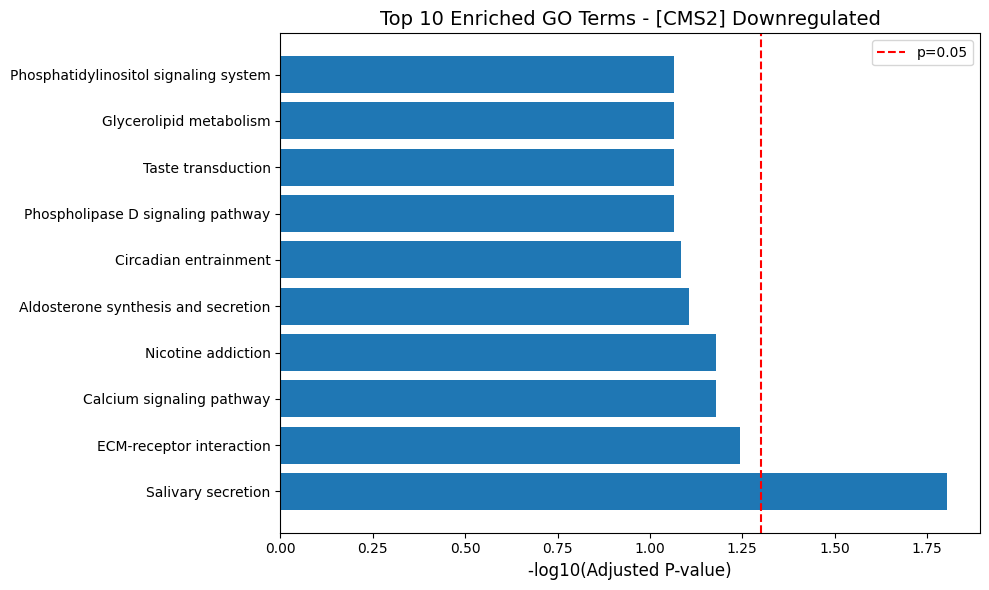

In [39]:
#bar plot
# Select top 10 terms by adjusted p-value
top_n = 10
top_terms = enr_down.results.head(top_n).copy()

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Sort by adjusted p-value (ascending)
top_terms = top_terms.sort_values('Adjusted P-value', ascending=True)

# Create bars
y_pos = np.arange(len(top_terms))
bars = ax.barh(y_pos, -np.log10(top_terms['Adjusted P-value']))

# Customize
ax.set_yticks(y_pos)
ax.set_yticklabels(top_terms['Term'], fontsize=10)
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12)
ax.set_title('Top 10 Enriched GO Terms - [CMS2] Downregulated', fontsize=14)
ax.axvline(x=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
ax.legend()

plt.tight_layout()
plt.savefig('enrichment_barplot_down.png', dpi=300, bbox_inches='tight')
plt.show()

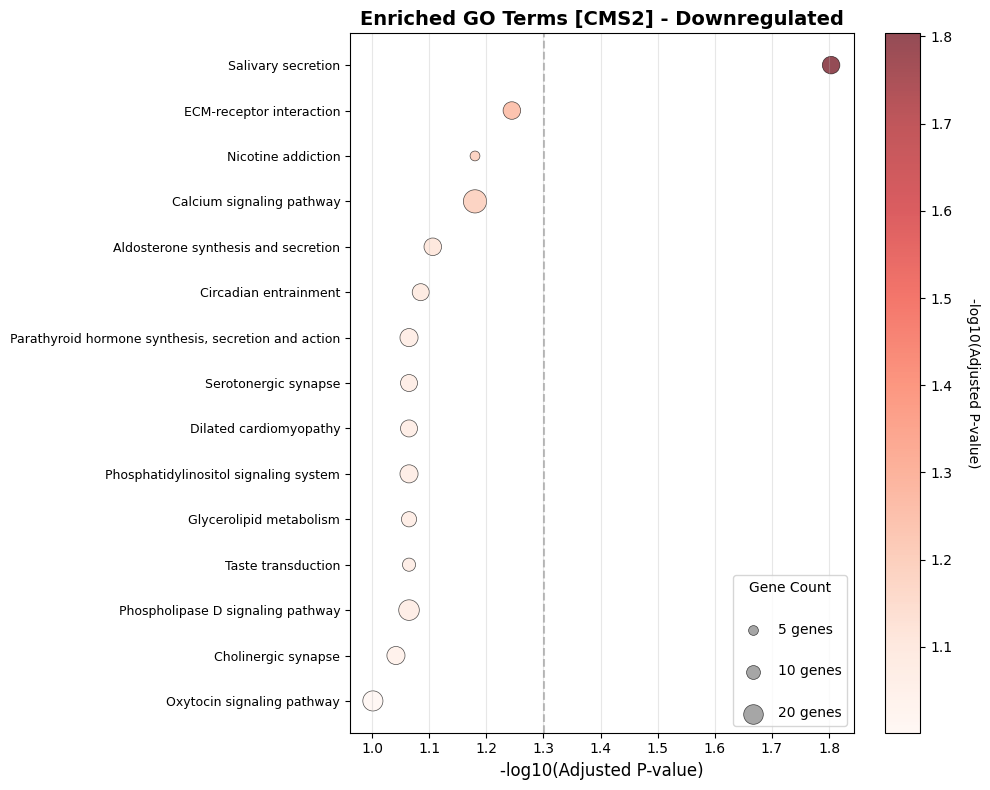

In [40]:
#dot plot
# Select top terms
top_n = 15
top_terms = enr_down.results.head(top_n).copy()
top_terms = top_terms.sort_values('Adjusted P-value', ascending=False)

# Create dot plot
fig, ax = plt.subplots(figsize=(10, 8))

# Extract data
terms = top_terms['Term']
pvals = -np.log10(top_terms['Adjusted P-value'])
gene_counts = top_terms['Genes'].str.split(';').str.len()  # Count genes separated by semicolon

# Create scatter
scatter = ax.scatter(pvals, np.arange(len(terms)), 
                     s=gene_counts*10,  # Size by number of genes
                     c=pvals,  # Color by p-value
                     cmap='Reds', 
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=0.5)

# Customize
ax.set_yticks(np.arange(len(terms)))
ax.set_yticklabels(terms, fontsize=9)
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12)
ax.set_title('Enriched GO Terms [CMS2] - Downregulated', fontsize=14, fontweight='bold')
ax.axvline(x=-np.log10(0.05), color='gray', linestyle='--', alpha=0.5)
ax.grid(axis='x', alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('-log10(Adjusted P-value)', rotation=270, labelpad=20)

# Add legend for size
sizes_to_show = [5, 10, 20]
for size in sizes_to_show:
    ax.scatter([], [], s=size*10, c='gray', alpha=0.7, 
               edgecolors='black', linewidth=0.5,
               label=f'{size} genes')
ax.legend(scatterpoints=1, frameon=True, labelspacing=2, 
          title='Gene Count', loc='lower right')

plt.tight_layout()
plt.savefig('enrichment_dotplot_down.png', dpi=300, bbox_inches='tight')
plt.show()

In [41]:
from gseapy import barplot, dotplot

# Bar plot
barplot(enr_down.results, 
        title='GO Enrichment - [CMS2] Downregulated',
        cutoff=0.05,
        top_term=15,
        figsize=(8, 6),
        ofname='gseapy_barplot_down.png')

# Dot plot
dotplot(enr_down.results,
        title='GO Enrichment - [CMS3] Downregulated', 
        cutoff=0.05,
        top_term=15,
        figsize=(6, 8),
        ofname='gseapy_dotplot_down.png')

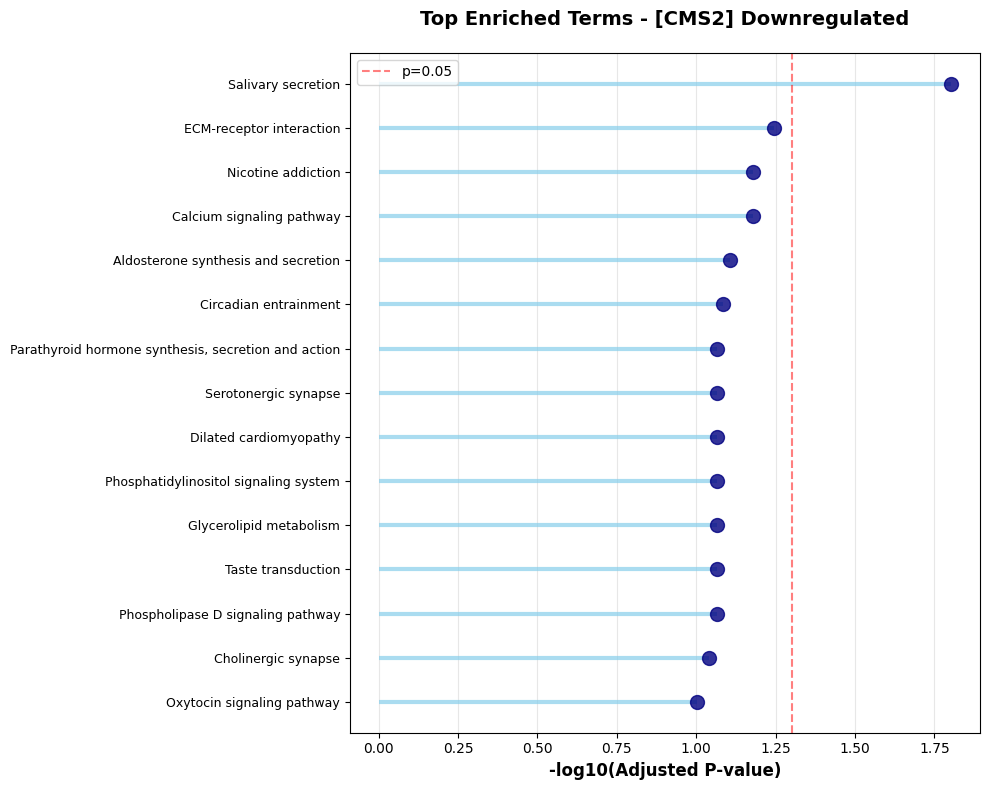

In [42]:
# Select top terms
top_n = 15
top_terms = enr_down.results.head(top_n).copy()
top_terms = top_terms.sort_values('Adjusted P-value', ascending=False)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Data
y_pos = np.arange(len(top_terms))
pvals = -np.log10(top_terms['Adjusted P-value'])

# Create lollipop
ax.hlines(y=y_pos, xmin=0, xmax=pvals, color='skyblue', alpha=0.7, linewidth=3)
ax.plot(pvals, y_pos, "o", markersize=10, color='navy', alpha=0.8)

# Customize
ax.set_yticks(y_pos)
ax.set_yticklabels(top_terms['Term'], fontsize=9)
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12, fontweight='bold')
ax.set_title('Top Enriched Terms - [CMS2] Downregulated', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=-np.log10(0.05), color='red', linestyle='--', 
           label='p=0.05', alpha=0.5)
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('enrichment_lollipop_down.png', dpi=300, bbox_inches='tight')
plt.show()

In [43]:
enr_down.results.to_csv('CMS2_Down_GO_enrichment.csv', index=False)

In [44]:
enr = gp.enrichr(gene_list= scvi_de[scvi_de['lfc_mean'] > 0].index.tolist(),
                 gene_sets=['KEGG_2021_Human','GO_Biological_Process_2023'],
                 organism='human', # don't forget to set organism to the one you desired!
                 outdir=None, # don't write to disk,
                 background = subset.var_names.tolist()
                )
enr

In [45]:
enr.results

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Fat digestion and absorption,0.000401,0.048136,0,0,24.134454,188.760750,FABP1;FABP2;PLA2G2A
1,KEGG_2021_Human,PPAR signaling pathway,0.004776,0.286553,0,0,9.541398,50.990926,FABP1;FABP2;FABP3
2,KEGG_2021_Human,Viral protein interaction with cytokine and cy...,0.012754,0.354398,0,0,6.556455,28.598819,CXCL8;CCL4L2;CXCL14
3,KEGG_2021_Human,Chemokine signaling pathway,0.018134,0.354398,0,0,4.205856,16.865323,CXCL8;GNG4;CCL4L2;CXCL14
4,KEGG_2021_Human,Arachidonic acid metabolism,0.022311,0.354398,0,0,9.266796,35.238717,PLA2G2A;PTGDS
...,...,...,...,...,...,...,...,...,...
790,GO_Biological_Process_2023,Regulation Of Gene Expression (GO:0010468),0.974379,0.980188,0,0,0.355072,0.009216,RAMP2;CXCL8
791,GO_Biological_Process_2023,Protein Modification Process (GO:0036211),0.979968,0.984343,0,0,0.252561,0.005111,PTPRO
792,GO_Biological_Process_2023,Positive Regulation Of DNA-templated Transcrip...,0.988701,0.991639,0,0,0.301130,0.003422,NPM1;GAL
793,GO_Biological_Process_2023,Regulation Of Transcription By RNA Polymerase ...,0.999483,0.999937,0,0,0.192235,0.000099,NPM1;GAL


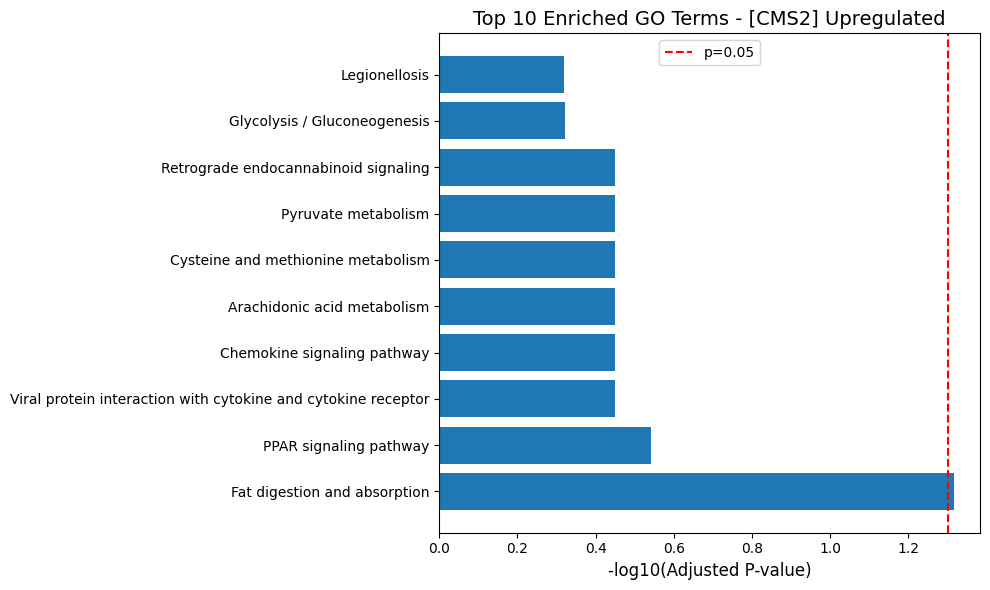

In [46]:
#bar plot
# Select top 10 terms by adjusted p-value
top_n = 10
top_terms = enr.results.head(top_n).copy()

# Create bar plot
fig, ax = plt.subplots(figsize=(10, 6))

# Sort by adjusted p-value (ascending)
top_terms = top_terms.sort_values('Adjusted P-value', ascending=True)

# Create bars
y_pos = np.arange(len(top_terms))
bars = ax.barh(y_pos, -np.log10(top_terms['Adjusted P-value']))

# Customize
ax.set_yticks(y_pos)
ax.set_yticklabels(top_terms['Term'], fontsize=10)
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12)
ax.set_title('Top 10 Enriched GO Terms - [CMS2] Upregulated', fontsize=14)
ax.axvline(x=-np.log10(0.05), color='red', linestyle='--', label='p=0.05')
ax.legend()

plt.tight_layout()
plt.savefig('enrichment_barplot_up.png', dpi=300, bbox_inches='tight')
plt.show()

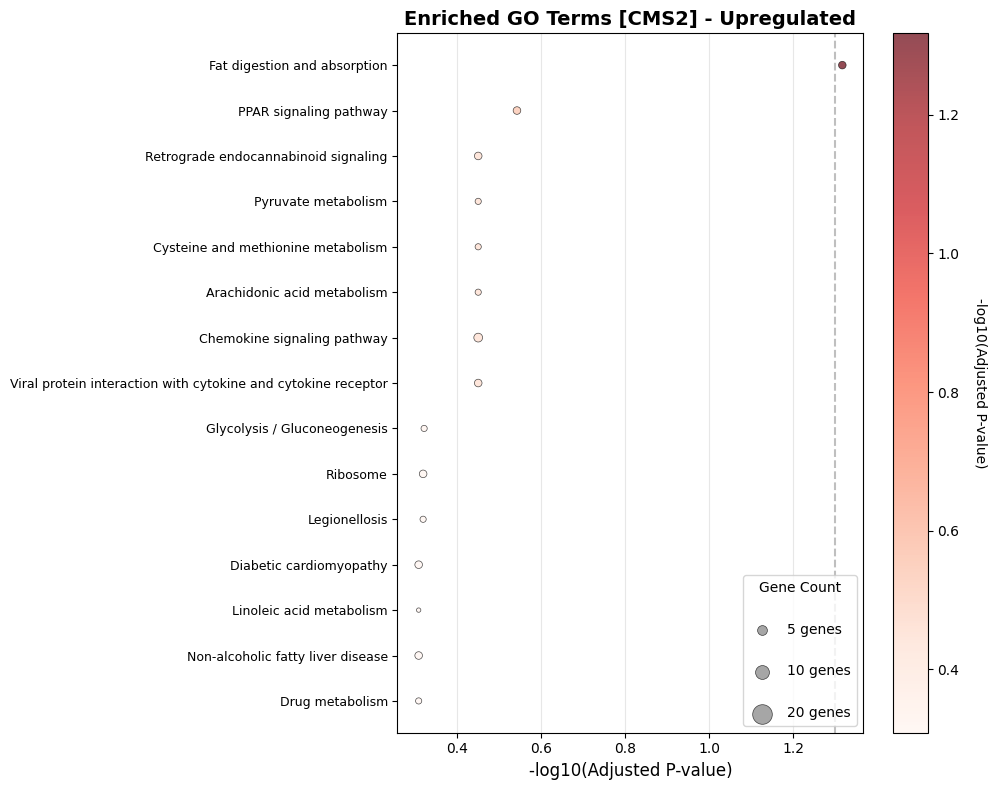

In [47]:
#dot plot
# Select top terms
top_n = 15
top_terms = enr.results.head(top_n).copy()
top_terms = top_terms.sort_values('Adjusted P-value', ascending=False)

# Create dot plot
fig, ax = plt.subplots(figsize=(10, 8))

# Extract data
terms = top_terms['Term']
pvals = -np.log10(top_terms['Adjusted P-value'])
gene_counts = top_terms['Genes'].str.split(';').str.len()  # Count genes separated by semicolon

# Create scatter
scatter = ax.scatter(pvals, np.arange(len(terms)), 
                     s=gene_counts*10,  # Size by number of genes
                     c=pvals,  # Color by p-value
                     cmap='Reds', 
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=0.5)

# Customize
ax.set_yticks(np.arange(len(terms)))
ax.set_yticklabels(terms, fontsize=9)
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12)
ax.set_title('Enriched GO Terms [CMS2] - Upregulated', fontsize=14, fontweight='bold')
ax.axvline(x=-np.log10(0.05), color='gray', linestyle='--', alpha=0.5)
ax.grid(axis='x', alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('-log10(Adjusted P-value)', rotation=270, labelpad=20)

# Add legend for size
sizes_to_show = [5, 10, 20]
for size in sizes_to_show:
    ax.scatter([], [], s=size*10, c='gray', alpha=0.7, 
               edgecolors='black', linewidth=0.5,
               label=f'{size} genes')
ax.legend(scatterpoints=1, frameon=True, labelspacing=2, 
          title='Gene Count', loc='lower right')

plt.tight_layout()
plt.savefig('enrichment_dotplot_up.png', dpi=300, bbox_inches='tight')
plt.show()

In [48]:

# Bar plot
barplot(enr.results, 
        title='GO Enrichment - [CMS2] Upregulated',
        cutoff=0.05,
        top_term=15,
        figsize=(8, 6),
        ofname='gseapy_barplot_up.png')

# Dot plot
dotplot(enr.results,
        title='GO Enrichment - [CMS2] Upregulated', 
        cutoff=0.05,
        top_term=15,
        figsize=(6, 8),
        ofname='gseapy_dotplot_up.png')

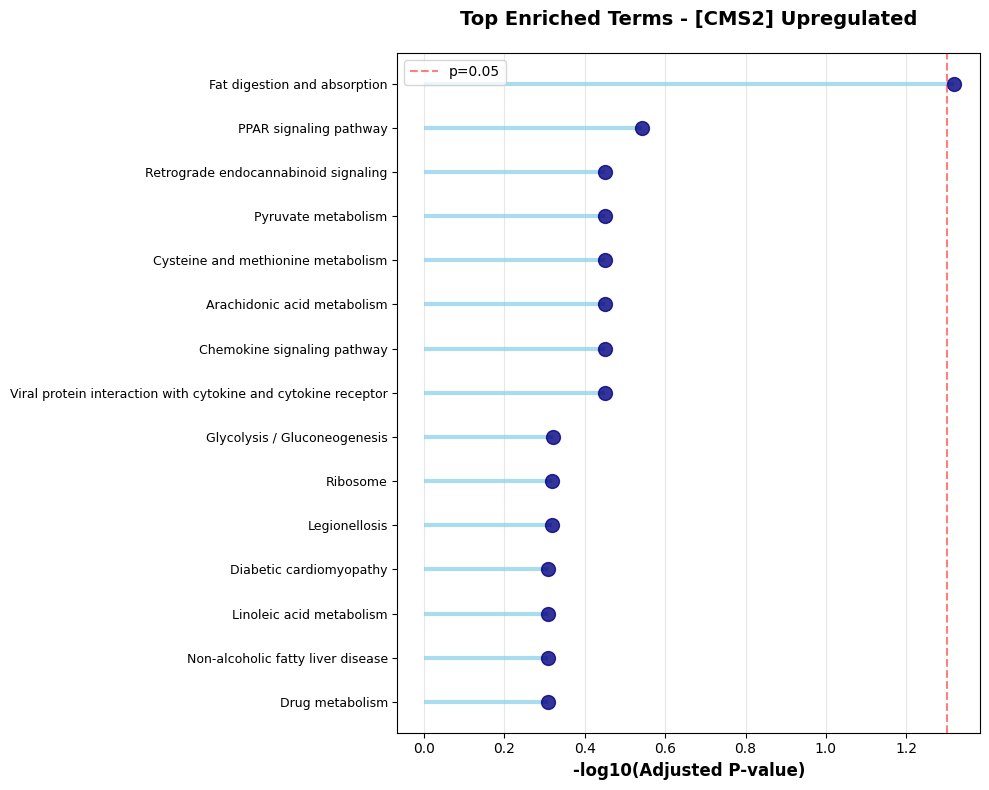

In [49]:
# Select top terms
top_n = 15
top_terms = enr.results.head(top_n).copy()
top_terms = top_terms.sort_values('Adjusted P-value', ascending=False)

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))

# Data
y_pos = np.arange(len(top_terms))
pvals = -np.log10(top_terms['Adjusted P-value'])

# Create lollipop
ax.hlines(y=y_pos, xmin=0, xmax=pvals, color='skyblue', alpha=0.7, linewidth=3)
ax.plot(pvals, y_pos, "o", markersize=10, color='navy', alpha=0.8)

# Customize
ax.set_yticks(y_pos)
ax.set_yticklabels(top_terms['Term'], fontsize=9)
ax.set_xlabel('-log10(Adjusted P-value)', fontsize=12, fontweight='bold')
ax.set_title('Top Enriched Terms - [CMS2] Upregulated', 
             fontsize=14, fontweight='bold', pad=20)
ax.axvline(x=-np.log10(0.05), color='red', linestyle='--', 
           label='p=0.05', alpha=0.5)
ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('enrichment_lollipop_up.png', dpi=300, bbox_inches='tight')
plt.show()

In [50]:
enr.results.to_csv('CMS2_Up_GO_enrichment.csv', index=False)